data source:

    https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=ratings_small.csv
    https://www.kaggle.com/datasets/asaniczka/tmdb-movies-dataset-2023-930k-movies?resource=download&select=TMDB_movie_dataset_v11.csv

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from tqdm import tqdm
import json
import pickle
import numpy as np
import os
from sklearn.preprocessing import MultiLabelBinarizer

### TMDB dataset

In [2]:
TMDB_movie = pd.read_csv("../data/TMDB_movie_dataset_v11.csv").dropna(subset=["popularity", "genres", "id"])
TMDB_rating = pd.read_csv("../data/ratings_small.csv").dropna(subset=["userId", "movieId", "rating", "timestamp"])
TMDB_rating.columns = ["userId", "id", "rating", "timestamp"]

merged_df = pd.merge(TMDB_movie, TMDB_rating, on="id", how="inner")
dataset = merged_df[["userId", "id", "rating", "timestamp", "popularity", "genres"]]

In [3]:
dataset.loc[:, "genres"] = dataset["genres"].apply(lambda x: x.replace("Science Fiction", "Science-Fiction"))
dataset.loc[:, "genres"] = dataset["genres"].apply(lambda x: x.replace("TV Movie", "tv-movie"))

In [4]:
dataset = dataset.loc[dataset['genres'].notna()]
dataset_scaled = dataset.copy()
dataset_scaled["popularity"] /= (dataset["popularity"].max() - dataset["popularity"].min())

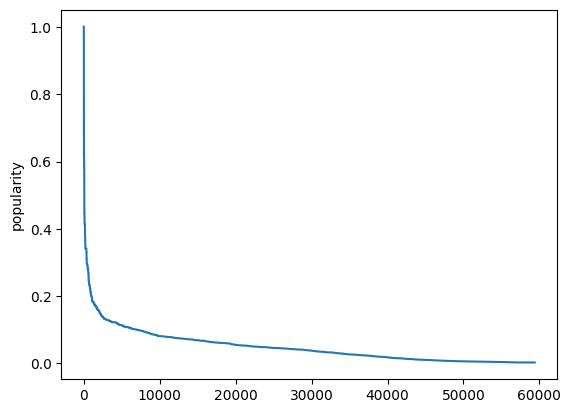

In [5]:
dataset_sorted = dataset_scaled.sort_values(by="popularity", ascending=False)

range_i = list(range(0, dataset_sorted.shape[0]))
sns.lineplot(x=range_i, y=dataset_sorted["popularity"])
plt.show()

In [6]:
dataset_sorted.head(5)

,userId,id,rating,timestamp,popularity,genres
22818,407,1880,4.0,962647016,1.001999,"Action, Thriller, War, Drama"
22817,41,1880,4.0,1093889528,1.001999,"Action, Thriller, War, Drama"
41,165,671,3.5,1111482370,0.617989,"Adventure, Fantasy"
45,346,671,5.0,1044650809,0.617989,"Adventure, Fantasy"
52,422,671,4.0,980859486,0.617989,"Adventure, Fantasy"


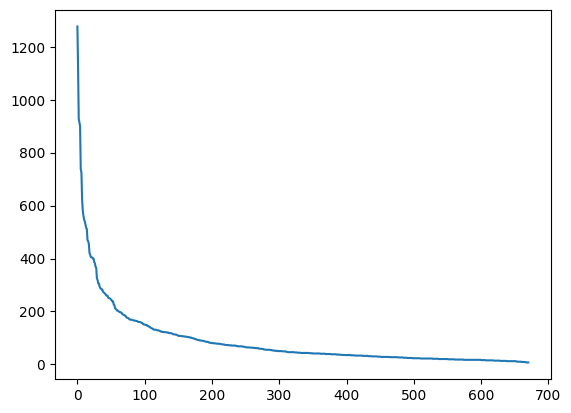

In [7]:
# count by movie id 
count = dataset_sorted["userId"].value_counts()
count = list(count)
count.sort(reverse=True)
count
range_i = list(range(0, len(count)))
sns.lineplot(x=range_i, y=count)
plt.show()

Create sparse/semantic matrix

In [8]:
def load_glove(words = None, glove_path = "../glove.6B/glove.6B.300d.txt", save_path = "../data/glove.json"):
    
    if "glove.json" in os.listdir("../data/"):
        with open(save_path, "r") as f:
            glove = json.load(f)
            f.close()
    else:
        glove = {}
        with open(glove_path, "r") as f:
            for line in tqdm(f):
                values = line.split()
                word = values[0]
                if words is None or word in words:
                    vector = np.asarray(values[1:], "float32")
                    glove[word] = vector.tolist()
            f.close()
        
        with open(save_path, "w") as f:
            json.dump(glove, f)
            f.close()
        
    return glove


genre_l = dataset_scaled['genres'].apply(lambda x :[ y.strip().lower().replace(' ','') for y in x.split(',')] )


MLB = MultiLabelBinarizer()

encoded = MLB.fit_transform(genre_l)

glove = load_glove(words = MLB.classes_)

sem_vec = []

for i in tqdm(range(len(genre_l))):
    sem_vec.append(np.array([glove[word] if word in genre_l[i] else np.zeros(300) for word in MLB.classes_ ]))

400000it [00:10, 38766.20it/s]
100%|██████████| 59390/59390 [00:06<00:00, 9627.64it/s]


In [9]:
data_preprocessed = dataset_scaled.copy()
data_preprocessed["sparse_genres"] = list(encoded)
data_preprocessed["sem_genres"] = list(sem_vec)

In [10]:
data_preprocessed.sort_values(by="timestamp", inplace=True)

In [11]:
pickle.dump(data_preprocessed, open("../data/preprocessed.pkl", "wb"))